<a href="https://colab.research.google.com/github/samirsebbah/mec-mini-projects/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Climate models are cost effective and efficient tools that scientists use to test their understanding of our climate system, and to predict future changes to our climate. Scientists use climate models to evaluate their understanding of the climate, and test out their hypotheses. $\ldots$ Because of the complexity of Earth’s climate, these models rely on parameterizations to approximate the effects of physical processes that occur at scales smaller than the size of their grid cells. These approximations are imperfect, however, and their imperfections are a leading source of uncertainty in expected warming, changing precipitation patterns, and the frequency and severity of extreme events. The Multi-scale Modeling Framework (MMF) approach, by contrast, more explicitly represents these subgrid processes, but at a cost too high to be used for operational climate prediction $\ldots$ [extracted from project page on Kaggle](https://www.kaggle.com/competitions/leap-atmospheric-physics-ai-climsim/overview).


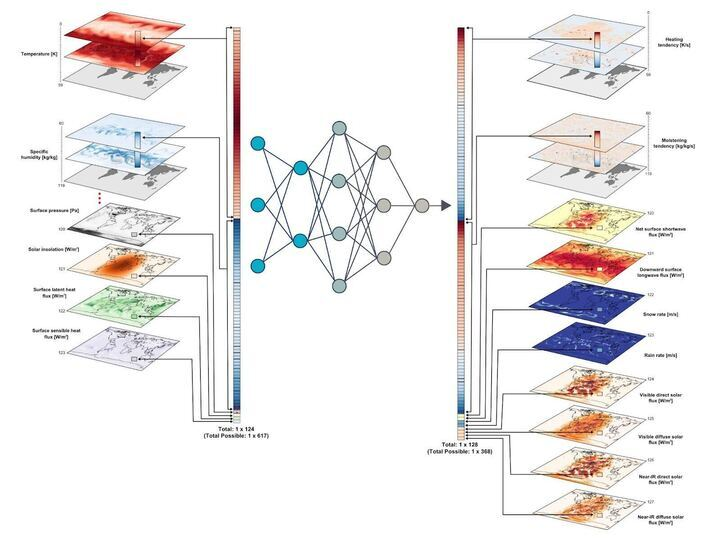

# Dataset
## Dataset Description

The dataset for the project is generated by the (E3SM-MMF) climate model ([More details about the data collection processes](https://www.kaggle.com/competitions/leap-atmospheric-physics-ai-climsim/data)). The multi-scale nature of E3SM-MMF allows it to explicitly resolve the effects of small-scale processes such as clouds and storms on large-scale climate patterns. Every row of the training set corresponds to the inputs and outputs of a cloud-resolving model (CRM) in E3SM-MMF at some location and timestep.

There are 556 columns corresponding to 25 input variables and 368 columns corresponding to 14 target variables. Some variables (like air temperature) span an entire atmospheric column and have 60 vertical levels, and other variables (like precipitation) are scalars. For the vertically resolved variables, an "_" followed by a number in the range [0,59] is appended to denote vertical level.

In this document, the variables with multiple dimensions are referred to as <b>composit variables</b>. The scaler variables are grouped together and referred to as <b>scaler variables</b>.

In this project, although high resolution data is available to use on HuggingFace, I am making use of a subset of the low-resolution data from ClimSim using the full variable list. The low-resolution dataset for both testing and training is of size 377.27 GB.





## Data Wrangling (Step5)

The first step of this project is to pull data from Kaggle to Google Drive and making it available for the EDA phase.
The zipped folder is of size 76G and contain both test and train data in separate files.



## Mount google drive to pull the input data


In [1]:
%%capture captured_output.log

from google.colab import drive
drive.mount('/content/drive')

# show details about the data
! zipinfo -1 /content/drive/MyDrive/Kaggle/leap-atmospheric-physics-ai-climsim.zip
! ls -alh /content/drive/MyDrive/Kaggle/leap-atmospheric-physics-ai-climsim.zip


# install latex
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super >> /dev/null

## Import libs and setup parameters

In [7]:
%%capture

import numpy as np
import pandas as pd
import os
from numpy import random

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from zipfile import ZipFile as zipfile

# activate Latex rendering
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# configs and params
MY_SEED = 43
TRAINING_SAMPLE_NBR_ROWS =1_000_000
MY_COLORS = ('darkblue','darkgreen','darkred')

pd.set_option('display.max_columns', None) # display all columns


# Set Google Drive as working directory.

# the base Google Drive directory
root_dir = "/content/drive/MyDrive/"
# location where project files to be saved
project_working_dir = "leap_sim_project"

# input folder of dataset
dataset_input_zip_folder = root_dir + '/Kaggle/leap-atmospheric-physics-ai-climsim.zip'
train_data_file_name = 'train.csv'
test_data_file_name = 'test.csv'
submission_data_file_name = 'sample_submission.csv'

## Helper methods

In [8]:
# setup input folder
def create_and_set_working_directory(project_folder):
    # check if your project folder exists. if not, it will be created.
    if os.path.isdir(root_dir + project_folder) == False:
        os.mkdir(root_dir + project_folder)
        print(root_dir + project_folder + ' did not exist but was created.')

    # change the OS to use your project folder as the working directory
    os.chdir(root_dir + project_folder)

    print('\n Working directory was changed to ' + root_dir + project_folder)

create_and_set_working_directory(project_working_dir)


# read a dataset from a zip folder
def read_dataset(dataset_input_zip_folder, train_data_file_name, nbr_rows=1, skiprows=0, cols=None):
    with zipfile(dataset_input_zip_folder) as z:
        with z.open(train_data_file_name) as f:
            df = pd.read_csv(f, nrows = nbr_rows, skiprows=skiprows, usecols=cols)
    return df

# visualize, with a hist plot, the distributions of features
def histplot_features_distributions (df, feature_name):
    v = df.columns
    fig, axs = plt.subplots(int(len(v)/4), 4, figsize=(50,100)) # 4 per row
    ax = axs.flatten()

    for i, col in enumerate(v):
        sns.histplot(df[col], ax=ax[i], color=MY_COLORS[np.random.choice(np.arange(0, len(MY_COLORS)))])
        ax[i].set_title(col)

    #plt.title(rf'Histograms of distributions for composit feature: $\textbf{{{feature_name}}}$')
    #fig.tight_layout(w_pad=6, h_pad=4)

    # Add a figure-wide title
    plt.suptitle(rf'Features distributions (histogram) of composit feature: $\textbf{{{feature_name}}}$', fontsize=24)

    # Adjust layout to prevent overlap between subplots and the title
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    #fig.tight_layout(w_pad=6, h_pad=4)

    plt.show()

# visualize, with boxplot, the distributions of the composit features
def boxplot_features_distributions (df, feature_name):

  # Melt the df
  df_melted = df.melt(var_name='Features', value_name='Values')

  fig = plt.figure(figsize=(16, 6))
  plt.xticks(rotation=90)

  # Draw the boxplot
  sns.boxplot(x='Features', y='Values', data=df_melted)
  plt.title(rf'Features distributions (boxplot) of composit feature: $\textbf{{{feature_name}}}$')
  # Show the plot
  fig.tight_layout(w_pad=6, h_pad=4)
  plt.show()



 Working directory was changed to /content/drive/MyDrive/leap_sim_project


# Composit features
In this section composit features are isolated.


1.   The variables with multiple dimensions are referred to as composit features. Each composit feature is composed of its 60 dimensional features
2.   The scaler variables are grouped together and referred to as scaler feature.



In [9]:
# sample the data
import re

# get the names of the output columns
df_submission_columns = read_dataset(dataset_input_zip_folder, submission_data_file_name, 0)

# composit and scaler target columns
target_cols = df_submission_columns.columns.to_list()
target_cols.remove('sample_id')
target_scalers_cols = target_cols

target_composits_cols = list()
target_composits = "ptend_t,ptend_q0001,ptend_q0002,ptend_q0003,ptend_u,ptend_v".split(",")

# dictionary of target composit feature to list of target features
all_target_features_of_composit_feature = dict()
for pattern in target_composits:
    all_target_features_of_composit_feature[pattern] = [x for x in target_cols if re.match(pattern + "_[0-9]+$",x)]
    target_scalers_cols = [x for x in target_scalers_cols if x not in all_target_features_of_composit_feature[pattern]]
    target_composits_cols.extend(all_target_features_of_composit_feature[pattern]) # keep a list of all columns

# read columns of input features
df_train_columns = read_dataset(dataset_input_zip_folder, train_data_file_name, 0)

features = [x for x in df_train_columns.columns.tolist() if x not in ['sample_id']+target_cols]
feature_scalers_cols = features
feature_composits_cols = list()
feature_composits = "state_t,state_q0001,state_q0002,state_q0003,state_u,state_v,pbuf_ozone,pbuf_CH4,pbuf_N2O".split(",")

# dictionary of composit input feature to list of input features
all_input_features_of_composit_feature = dict()
for pattern in feature_composits:
    all_input_features_of_composit_feature[pattern] = [x for x in features if re.match(pattern + "_[0-9]+$",x)]
    feature_scalers_cols = [x for x in feature_scalers_cols if x not in all_input_features_of_composit_feature[pattern]]
    feature_composits_cols.extend(all_input_features_of_composit_feature[pattern])

# EDA

Given the size of the input data, we decided to draw samples, instead of loading the whole data, for the EDA.
The input data is handled in batches of features, referred to as composit features. Each compist feature is composed of a group of vertically resolved variables in the raw data. The scaler features are also groupped together under a composit name *scaler*


In the following, we explore some aspects of the data to gain insights about its distribution and correlation.
Our main objective in this project is to come up with a subsets of features/data points to feed a model for improved scalability and efficiency.

The below analysis is to performance some statistical analysis to study the data distributions and correlations. Each composit feature is separately loaded, analyzed, and exported for the ML model to use.





In [ ]:
# Sample the data: read all input feature
# the features of a composit feature are read under the composit feature name
# the scaler features are read under 'scaler' name

input_features = dict()

# load each composit feature into a df
for feature in feature_composits:
  input_features[feature] =  read_dataset(dataset_input_zip_folder, train_data_file_name, nbr_rows=TRAINING_SAMPLE_NBR_ROWS, cols=all_input_features_of_composit_feature[feature])

# loading the scaler features under a composit name 'scaler'
input_features["scaler"] =  read_dataset(dataset_input_zip_folder, train_data_file_name, nbr_rows=TRAINING_SAMPLE_NBR_ROWS, cols=feature_scalers_cols)

# loading the scaled output variables
output_data =  read_dataset(dataset_input_zip_folder, train_data_file_name, nbr_rows=TRAINING_SAMPLE_NBR_ROWS, cols=target_composits_cols)

In [13]:
## describe: Input composit feature

for feature in input_features.keys():
  print(input_features[feature].describe())
  break # comment to see all the features



            state_t_0       state_t_1       state_t_2       state_t_3  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean       215.170996      227.448849      237.183836      247.999570   
std          7.083899        8.781638        8.387459        6.968301   
min        154.619922      139.066952      168.246148      203.463584   
25%        210.958564      221.737519      231.615478      243.717104   
50%        215.211379      227.692148      236.503888      247.190550   
75%        219.283362      233.544442      242.062411      251.264028   
max        427.707429      313.808117      289.949010      308.059866   

            state_t_4       state_t_5       state_t_6       state_t_7  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean       256.542024      259.751268      255.567898      247.047336   
std          5.914274        7.473869        9.366398        9.490694   
min        218.180164      213.326016      207.237

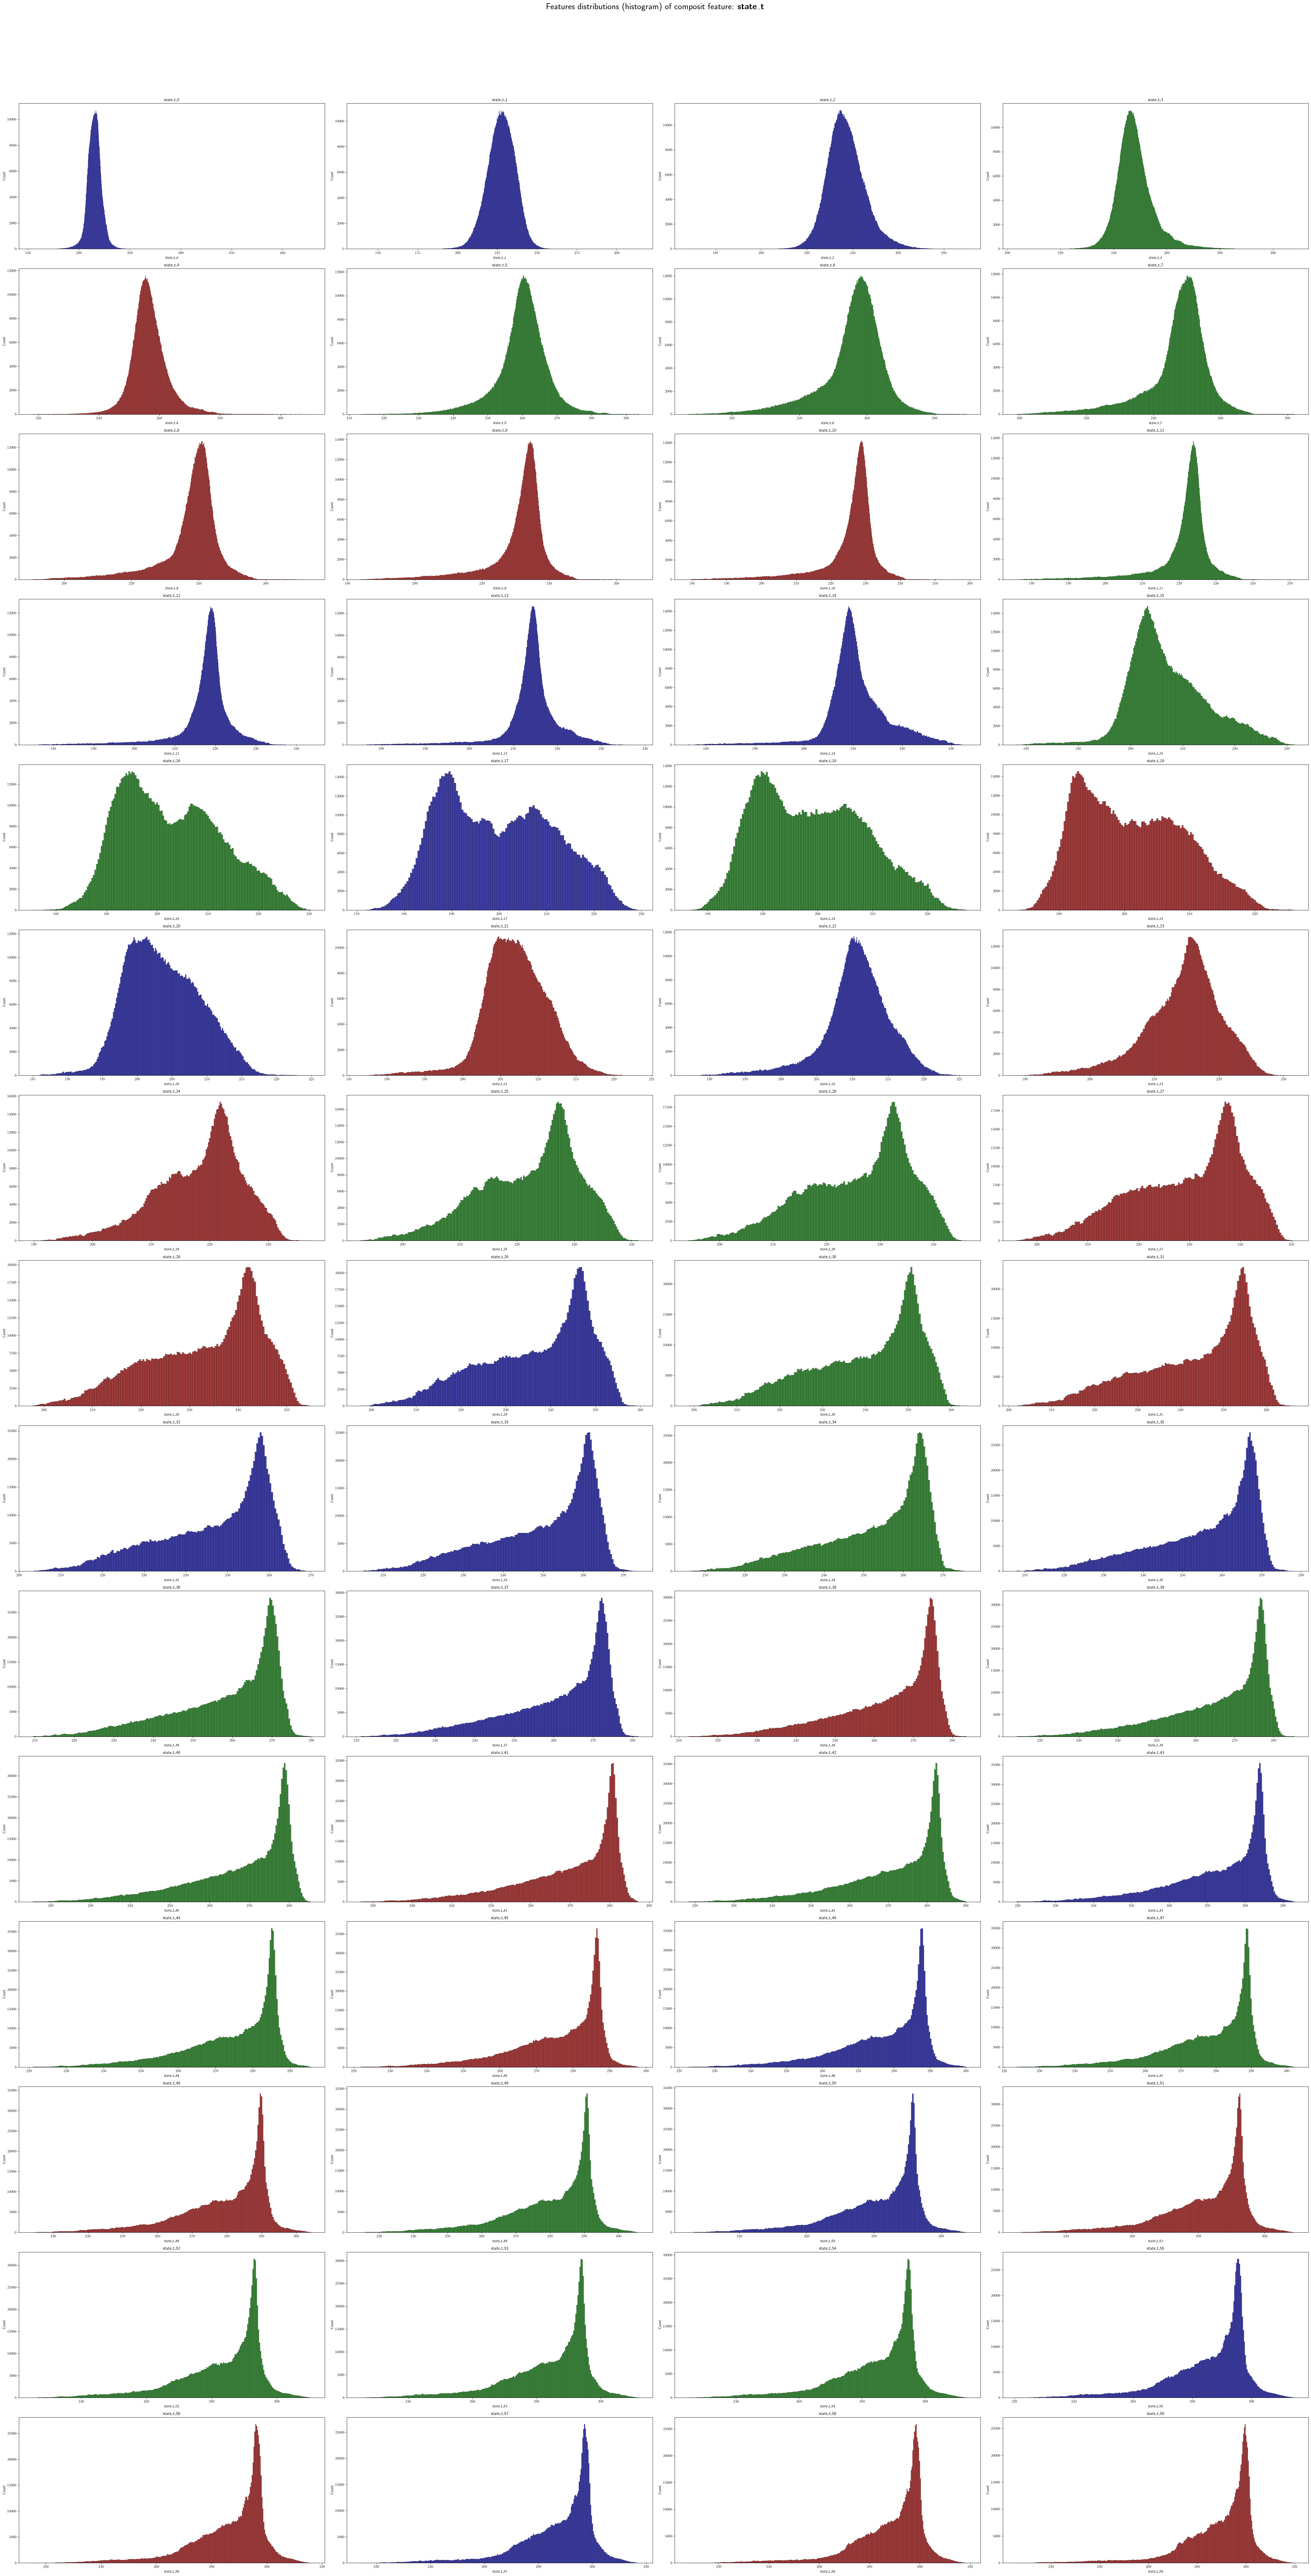

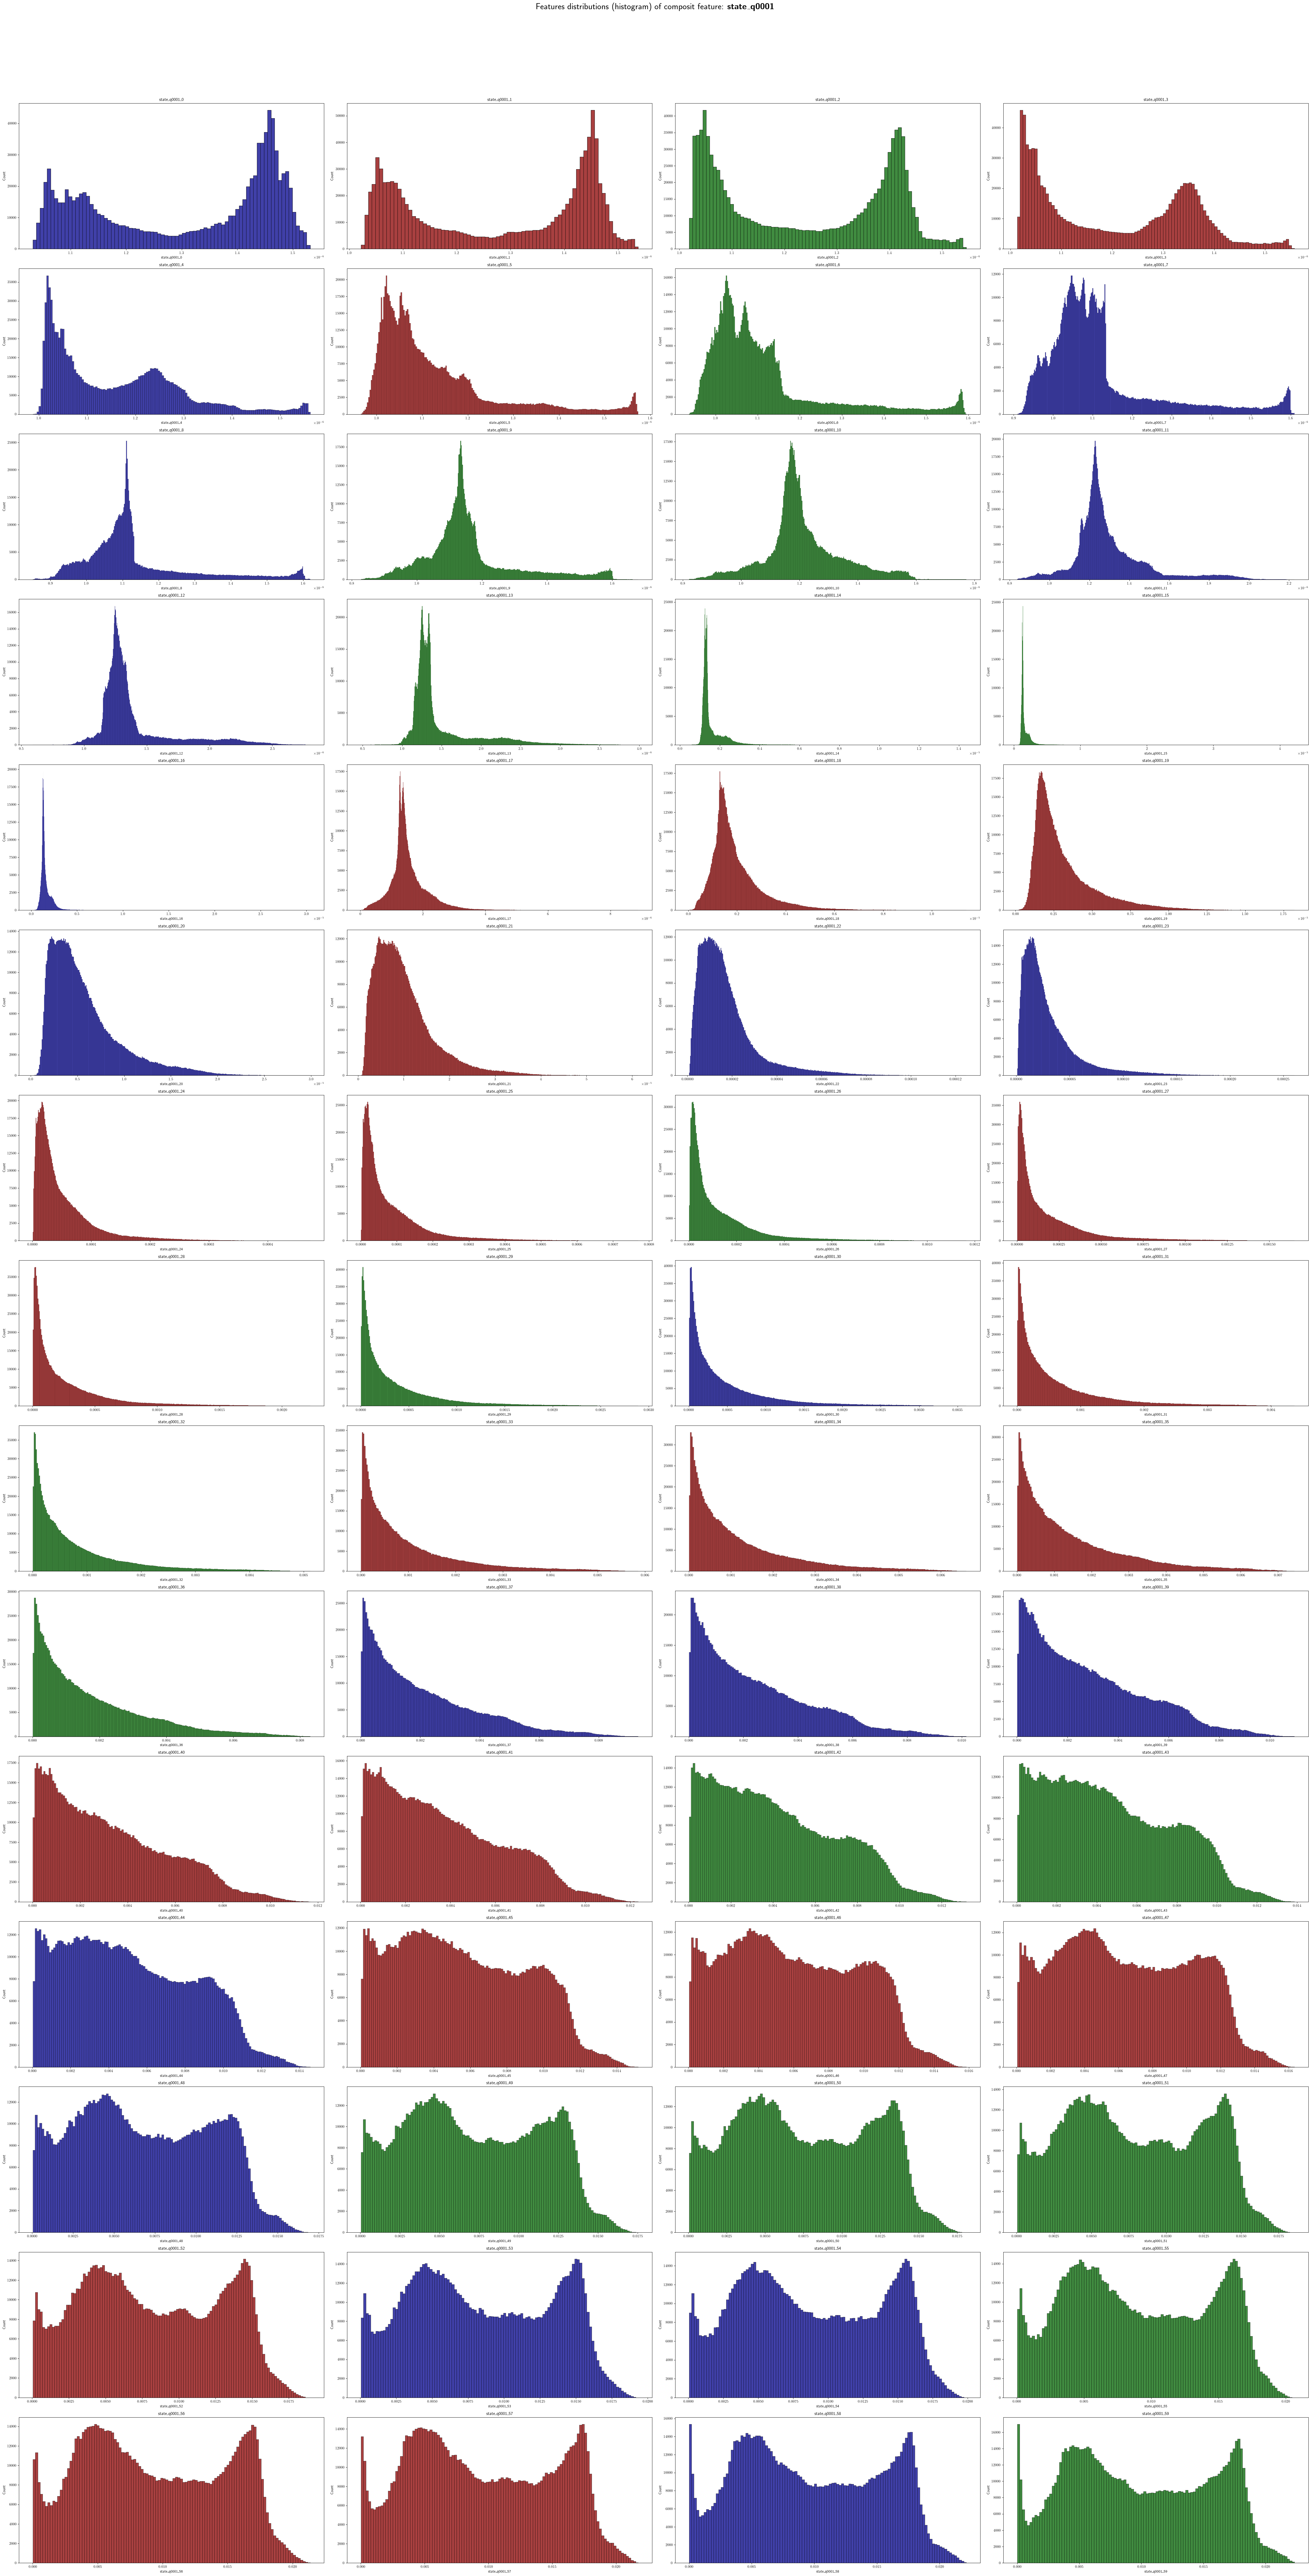

In [ ]:
## visualize: Input feature: histplot of all the composit features and scaler features
# each composit feature is plotted separately.

for feature in input_features.keys():
  histplot_features_distributions (input_features[feature], feature)
  #break # comment out to see all the features

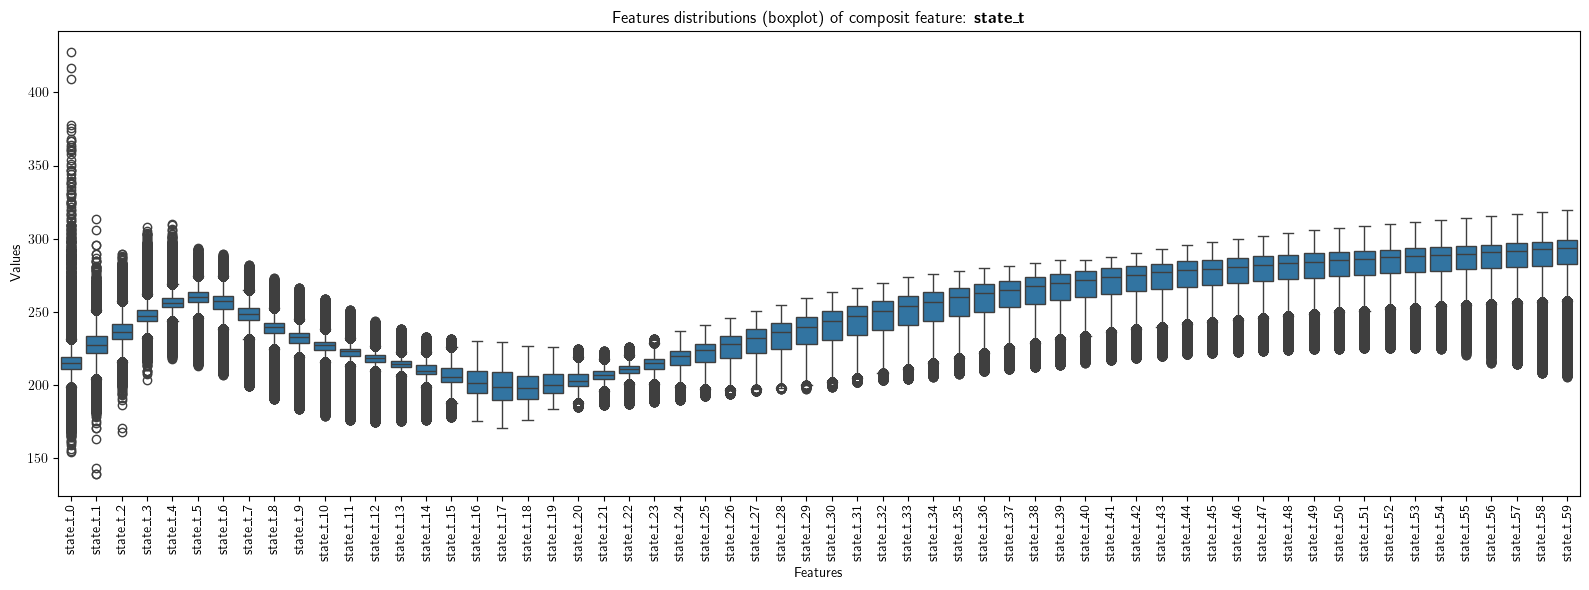

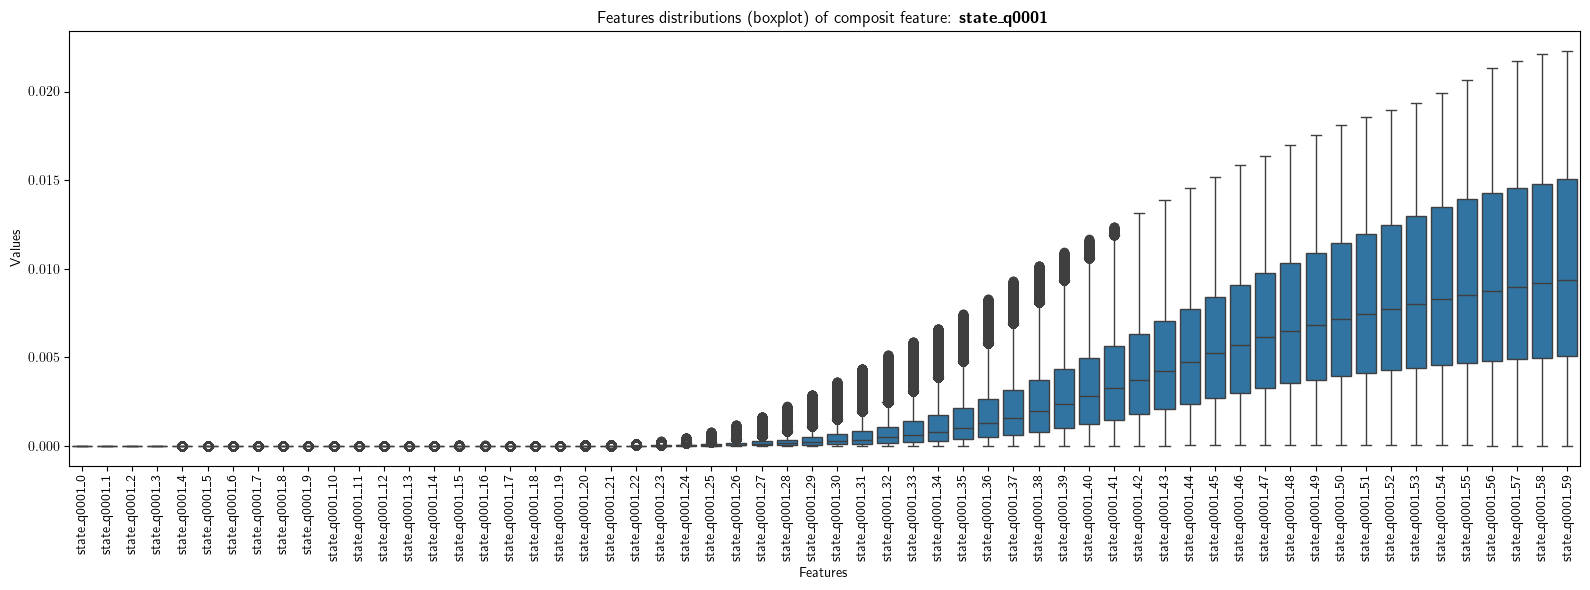

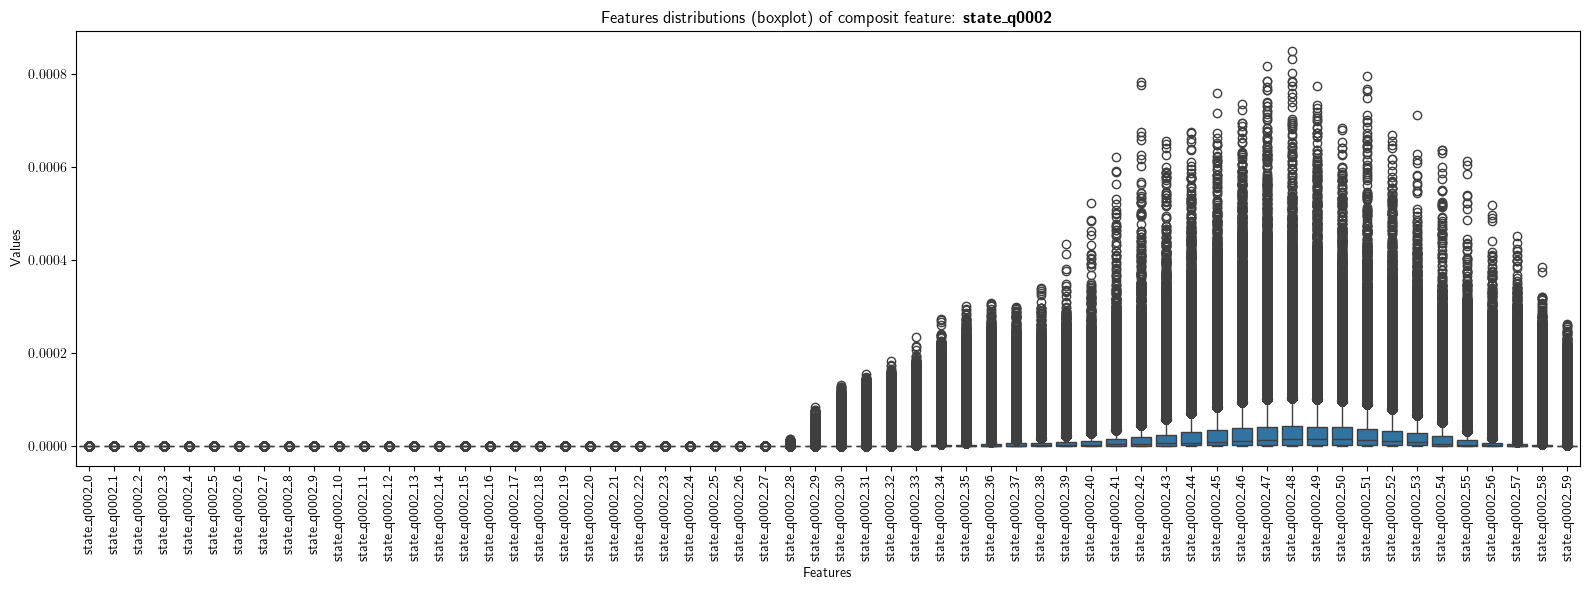

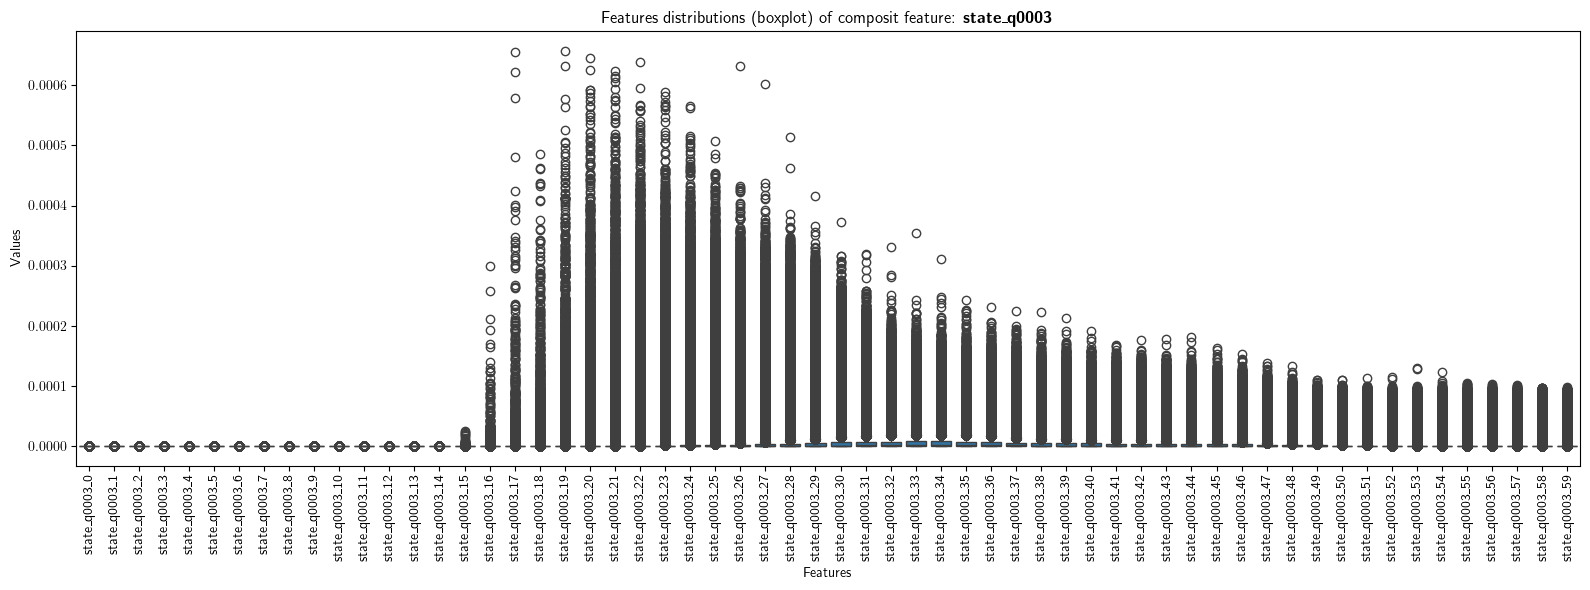

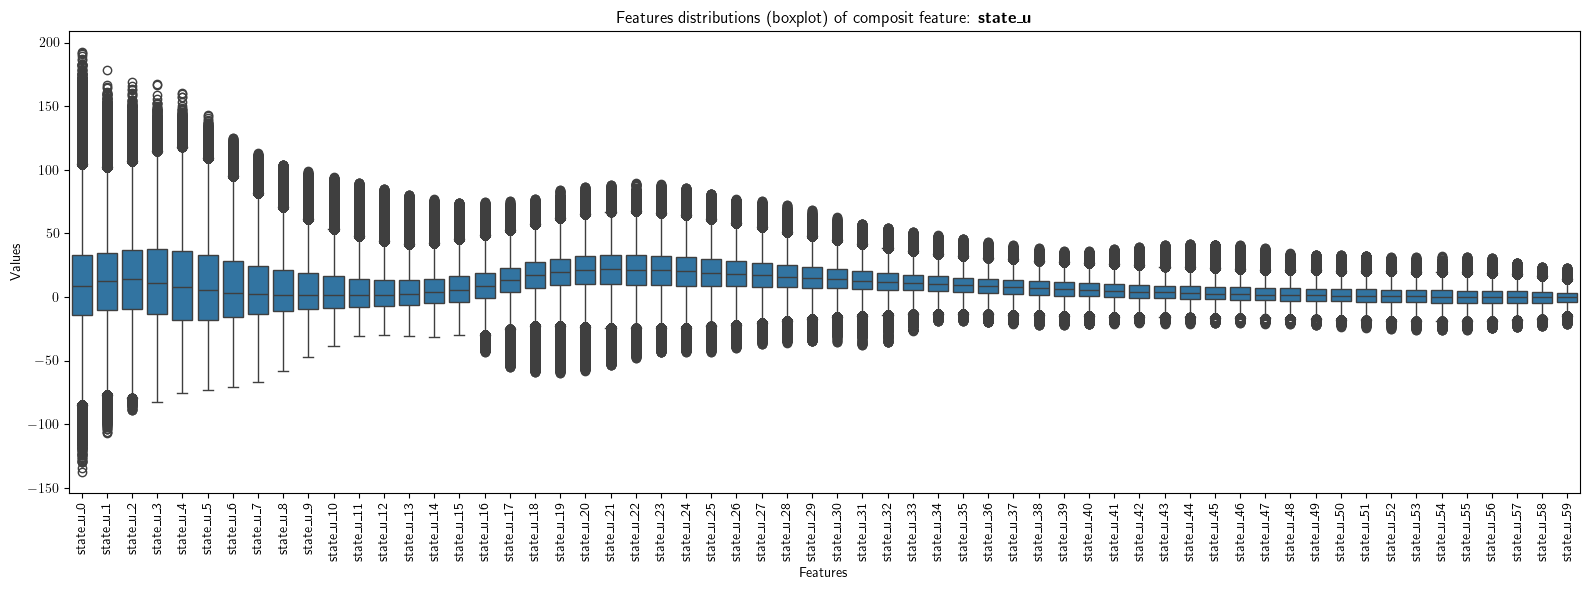

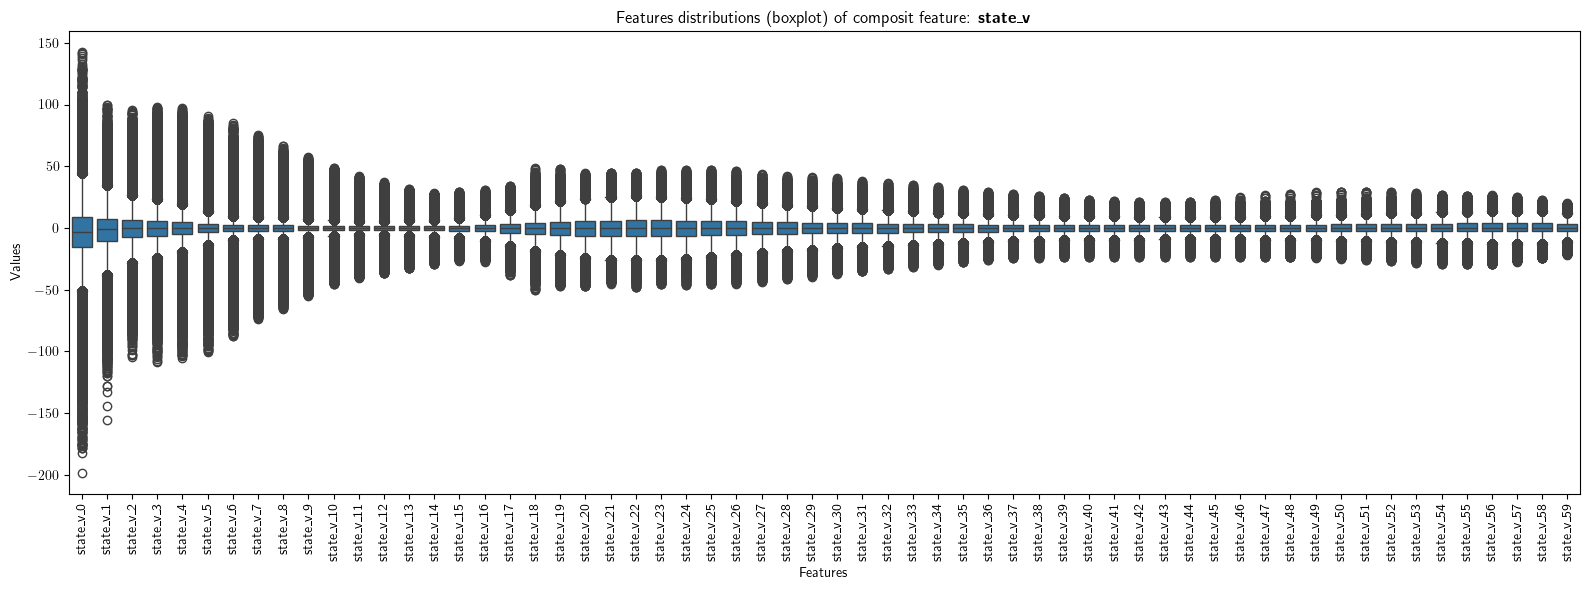

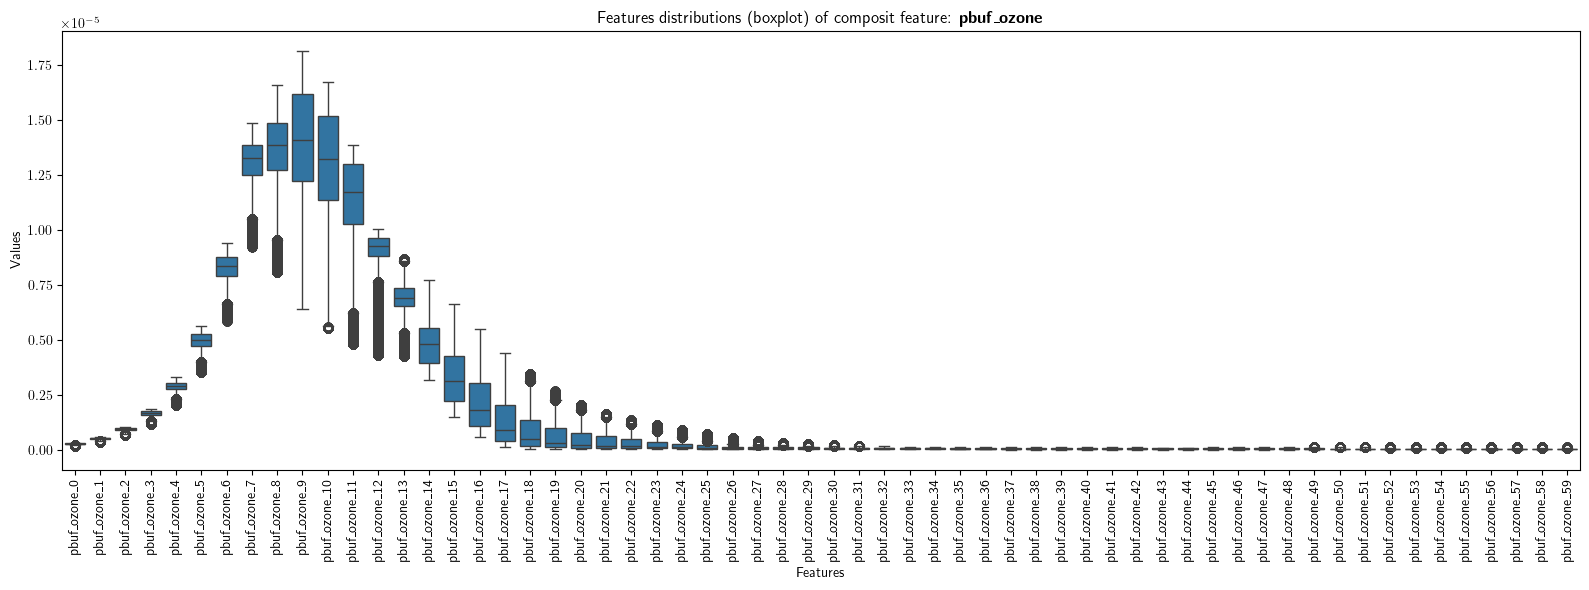

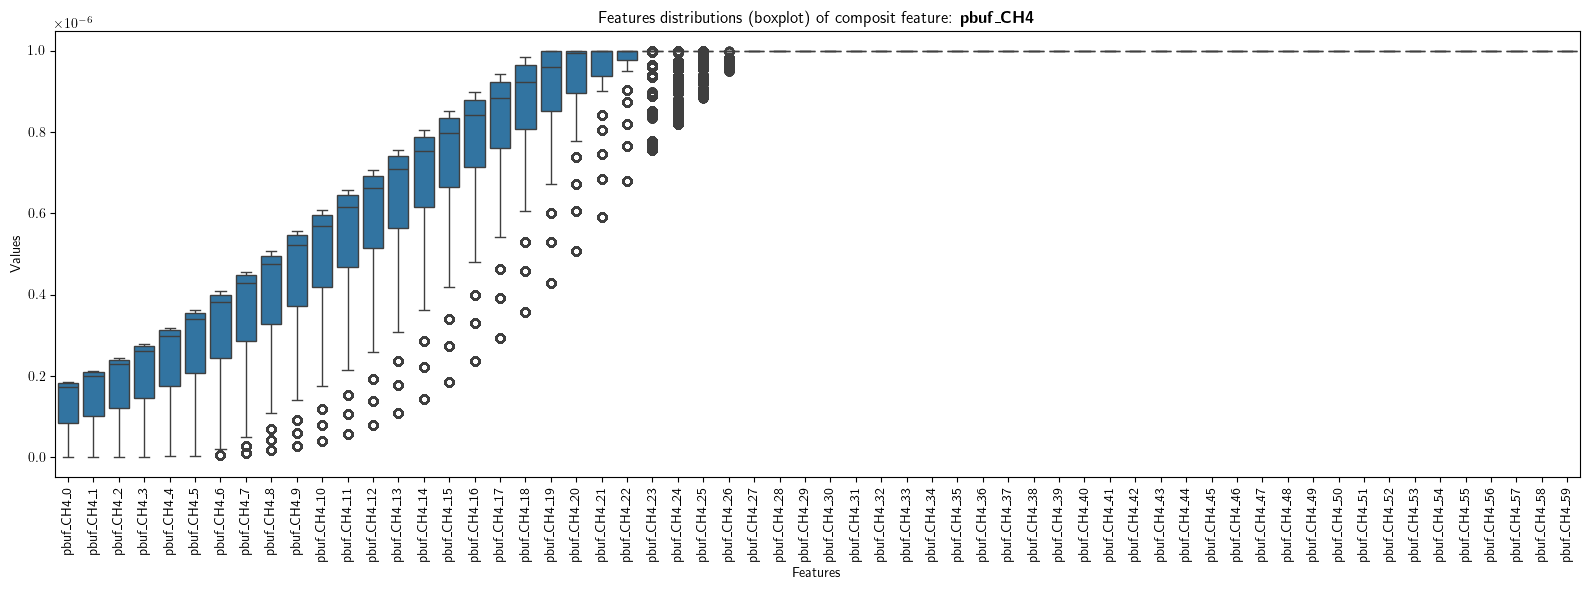

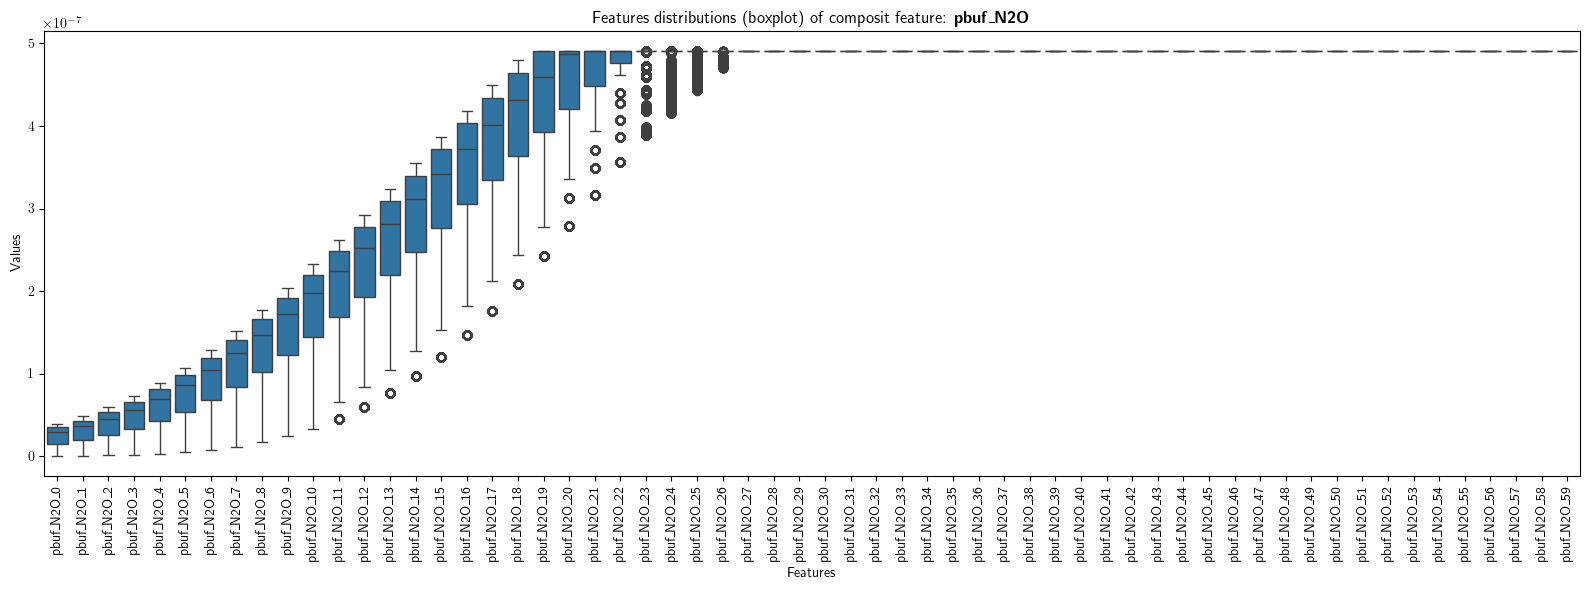

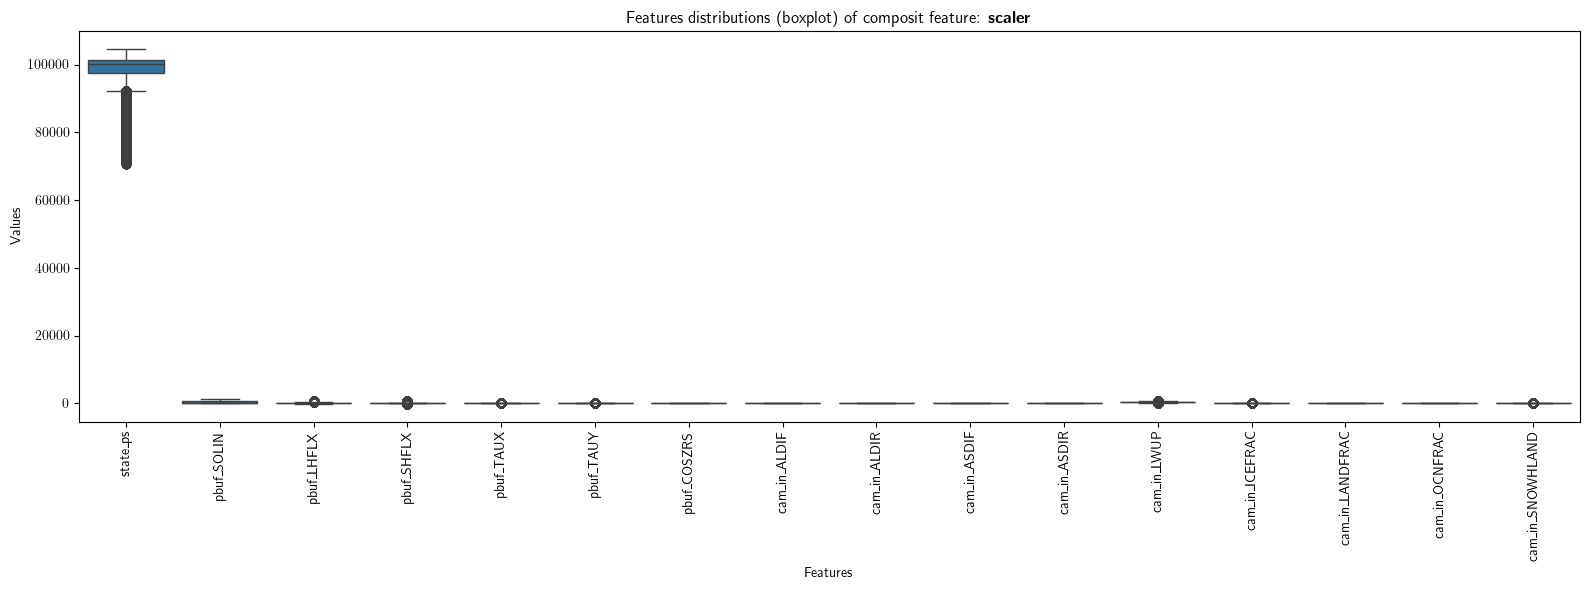

In [15]:
for feature in input_features.keys():
  boxplot_features_distributions (input_features[feature], feature)

Measure correlations of the input features within the composit features

In [16]:
from scipy import stats
from scipy.stats.mstats import pearsonr

def get_correlation_matrix(df):
  index_all_features = df.columns
  correlationMatrix = pd.DataFrame(data=[],index=index_all_features, columns=index_all_features)
  for i in index_all_features:
    for j in index_all_features:
        correlationMatrix.loc[i,j] = np.round(pearsonr(df.loc[:,i], df.loc[:,j])[0],2)

  return correlationMatrix

def display_high_correlation_df(correlationMatrix, threshold = 0.8):
  hc = correlationMatrix[(correlationMatrix>0.8) | (correlationMatrix<-0.8)]
  for cnt_col, col in enumerate(correlationMatrix.columns):
    for cnt_idx, idx in enumerate(hc.index):
        if cnt_idx>cnt_col: #symmetrical matrix
            if hc.loc[idx, col]>threshold or hc.loc[idx, col]< - threshold:
                print(f"correlation of {idx}, {col}, is {hc.loc[idx, col]}")



# display the correction distribution
def visualize_correlation_distribution(correlation_df, composit_feature_name=""):
  index_all_features = correlation_df.columns

  arr = correlation_df.to_numpy().flatten()

  # Creating a customized histogram with a density plot
  sns.histplot(arr, bins=200, kde=True, color=MY_COLORS[np.random.choice(np.arange(0, len(MY_COLORS)))], edgecolor=MY_COLORS[np.random.choice(np.arange(0, len(MY_COLORS)))])

  # Adding labels and title
  plt.xlabel('Correaltion Values')
  plt.ylabel('Density')
  plt.title(rf'Correlation density distribution for composit feature: $\textbf{{{composit_feature_name}}}$')

  # Display the plot
  plt.show()


In [17]:

correlations_of_feature = dict()
for feature in feature_composits + ["scaler"]:
  correlations_of_feature[feature] = get_correlation_matrix(input_features[feature])

# uncomment to see the values of the highly correlated features
#display_high_correlation_df(dd, 0.9)

# Correlation analysis
In this section, we analyze the correlation distribution of the features. Per composit feature, the plots show the correlation distribtion of the features within each of the composit features.  

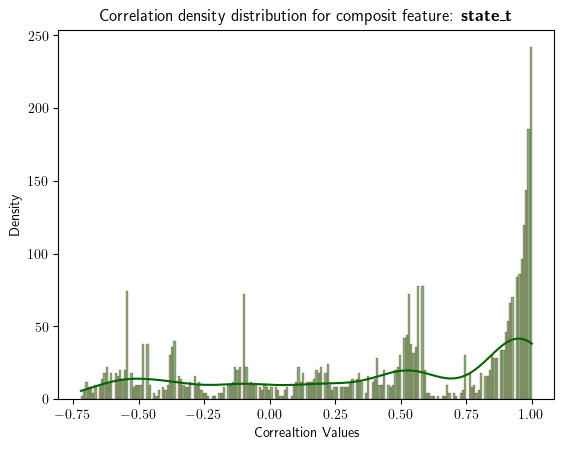

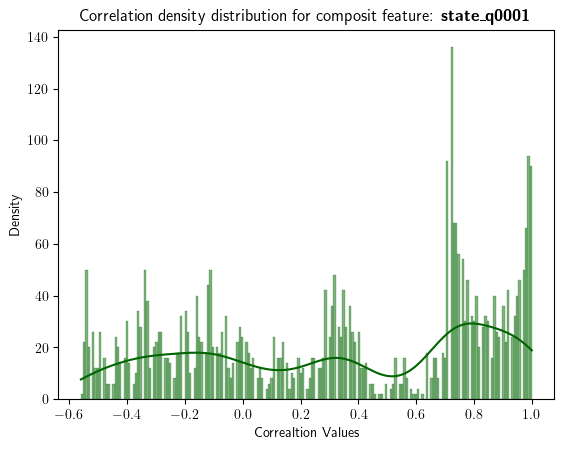

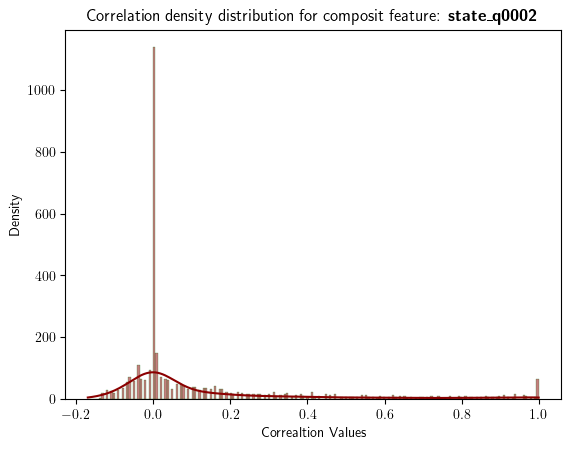

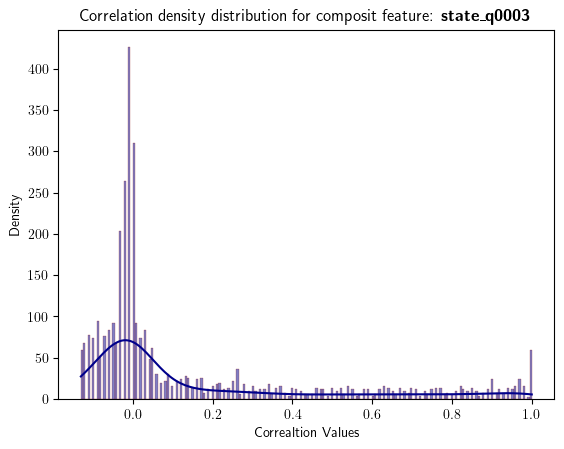

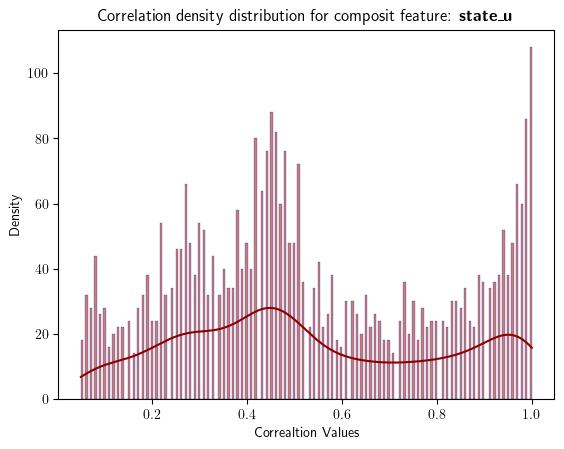

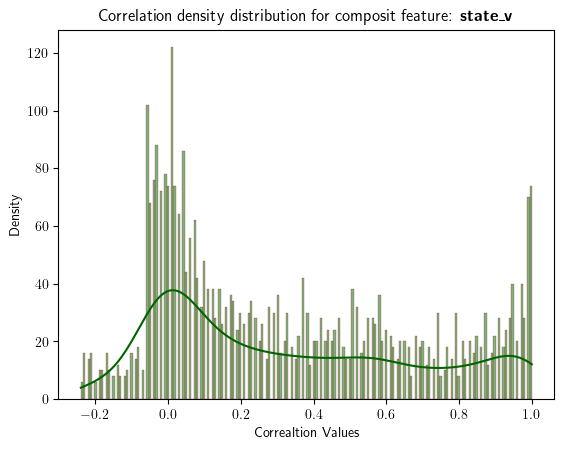

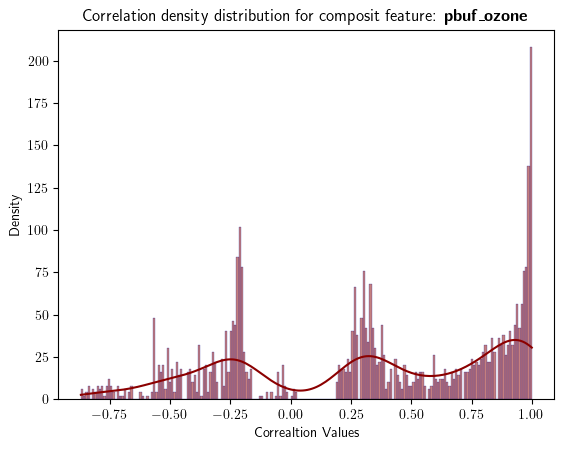

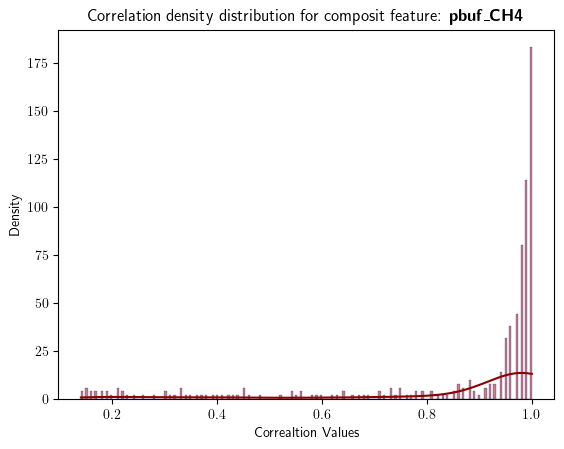

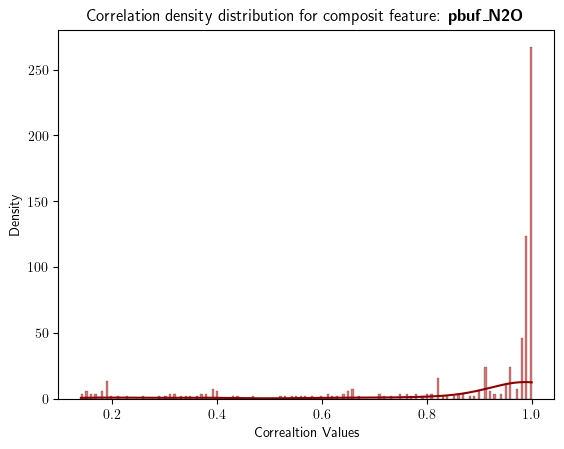

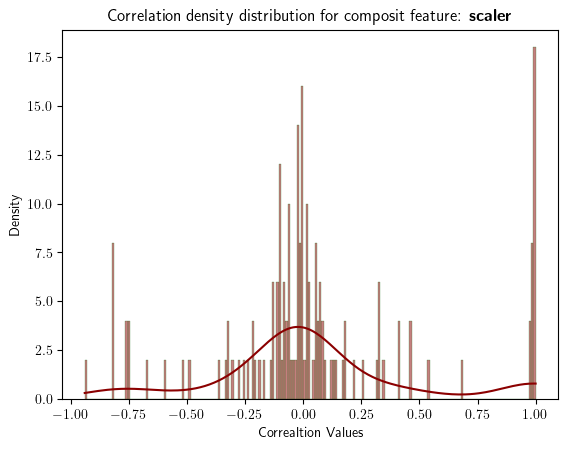

In [18]:
for feature in feature_composits + ["scaler"]:
  visualize_correlation_distribution(correlations_of_feature[feature], feature)

# Observations
Looking thru the sampled data we notice

<ol>
<li> Domains of the different distributions span different ranges even within the same composit features</li>
<li>Within the same composit features, some features seem to have the same data distribution - indicator of correlations</li>
<li> Within each composit feature, the correlation plots show strong correlations among the features
<li> Within each composit feature, all the strong correlations (>0.98) are positive
</li>
</ol>

Based on the observation above, we decided to

1.   Scale the data to transform the features to a consistent range.
2.   Run a PCA model to reduce the data input size and select the relevant features to reduce/eliminate correlations

More opportunities
1.   Adopt a scaling cusomized for each of the composit features. The data distributions are different, some distrbutions are nearing zero and bearily visible on the plots.
2.   Outliers are present in every measure, finding a strategy to handle those in order to bring more stability to the learning process in the ML model



# PCA to select the minimal set of scaled features

In the following, we use a standard scaling method to transform the data then a PCA method to reduce the number of input features.
Scaling the input features and the output data is crucial for many machine learning algorithms, especially those that rely on distance measurements, gradients, or assumptions of data distributions. For the output data, when the output values are large, scaling the target data can stabilize training and allow the model to converge faster.

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# export the models
import joblib

# scale the data
def scale_data (df):
  # Standardize the data
  scaler = StandardScaler()

  return scaler.fit_transform(df)

def run_pca_then_export_model(nd_array, n_components, output_file_name):

  # Create a PCA object, retaining the requested variance
  pca_model = PCA(n_components=n_components)

  # Fit PCA on the data
  pca_model.fit(nd_array)

  # Transform data into principal components
  pca_data = pca_model.transform(nd_array)

  # original number of features
  print(f"The number of original features: {nd_array.shape[1]}")

  # Number of selected principal components
  print(f"The number of principal components selected: {pca_model.n_components_}")

  # export the model
  joblib.dump(pca_model, output_file_name)

  return pd.DataFrame(pca_data)


def export_data_to_parquet (df, output_file_name):
  # export the data to parquet
  df.to_parquet(output_file_name)



# input data, scale, run pca and export model, then export pca to parquet files
for feature in feature_composits + ["scaler"]:
  scaled_data = scale_data(input_features[feature])
  print("Composit feature: ", feature)
  transformed_data = run_pca_then_export_model(scaled_data, 0.98, "composit_feature_" + feature + "_pca_model2.pkl")
  export_data_to_parquet(transformed_data, "composit_feature_" + feature + "_df2.parquet")

# output data, scale data then export data to a parquet file
scaled_data = scale_data(output_data)
export_data_to_parquet(pd.DataFrame(scaled_data), "output_df2.parquet")

Composit feature:  state_t
The number of original features: 60
The number of principal components selected: 9
Composit feature:  state_q0001
The number of original features: 60
The number of principal components selected: 13
Composit feature:  state_q0002
The number of original features: 60
The number of principal components selected: 30
Composit feature:  state_q0003
The number of original features: 60
The number of principal components selected: 22
Composit feature:  state_u
The number of original features: 60
The number of principal components selected: 8
Composit feature:  state_v
The number of original features: 60
The number of principal components selected: 14
Composit feature:  pbuf_ozone
The number of original features: 60
The number of principal components selected: 6
Composit feature:  pbuf_CH4
The number of original features: 60
The number of principal components selected: 3
Composit feature:  pbuf_N2O
The number of original features: 60
The number of principal components s

# Observations

1.   the pca model picked more components to achieve 98% variability within compoist features with low correlations, e.g., state_q0002

2.   the pca model picked a very low percent of features to achieve 98% variability within composit features with high correlations, e.g., pbuf_CH4, pbuf_N20



In [ ]:
# Install nbconvert
!pip install nbconvert

# Convert the notebook to Markdown
!jupyter nbconvert --to markdown "/content/drive/MyDrive/Colab Notebooks/EDA.ipynb" --output-dir="/content/drive/MyDrive/Colab Notebooks/exports/"